In [1]:
from typing import List, Tuple, Dict
from sklearn.neighbors import KNeighborsClassifier
from utils import *

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

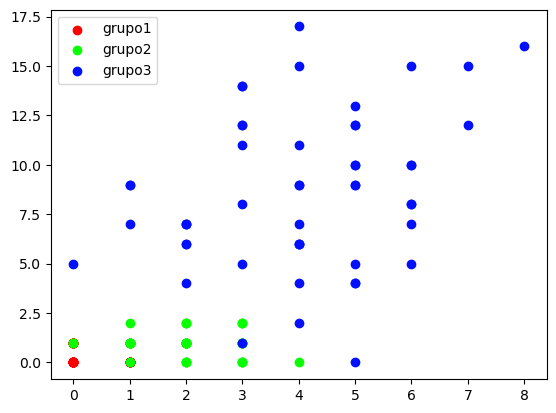

Puntos_nuevos: [array([100, 150]), array([1, 1]), array([  1, 300]), array([80, 40]), array([400, 400])], etiquetas predichas: ['grupo3', 'grupo2', 'grupo3', 'grupo3', 'grupo3']


In [2]:
def normalizar_distribucion(distribucion: np.array, n: int) -> np.array:
    """
    Normaliza una distribución dada para sumar aproximadamente a n.

    Args:
    - distribucion (np.array): Vector de NumPy que representa la distribución.
    - n (int): Suma deseada para la distribución normalizada

    Returns:
    - np.array: Distribución normalizada redondeada.
    """
    # Ajusta la distribución para que no contenga valores negativos
    b = distribucion - min(distribucion) + 0.000001
    # Normaliza la distribución para que sume aproximadamente a n
    c = (b / np.sum(b)) * n
    # Redondea los valores para obtener una distribución discreta
    return np.round(c)

def crear_distribucion(media: float, tamano: int) -> pd.Series:
    """
    Crea una serie de Pandas con una distribución normalizada alrededor de la
    media dada.

    Args:
    - media (float): Media de la distribución deseada.
    - tamano (int): Tamaño de la muestra de la distribución.

    Returns:
    - pd.Series: Serie de Pandas que representa la distribución creada.
    """
    distribucion_normal = np.random.standard_normal(tamano)
    distribucion_normalizada = normalizar_distribucion(distribucion_normal,
                                                        media)
    return pd.Series(distribucion_normalizada)

def generar_df(medias: List[Tuple[float, float, str]], n: int) -> pd.DataFrame:
    """
    Genera un DataFrame a partir de una lista de medias y tamaños para las
    distribuciones.

    Args:
    - medias (List[Tuple[float, float, str]]): Lista de tripletas (medias  de
    x, medias de y y etiquetas).
    - n (int): Tamaño de cada distribución generada.

    Returns:
    - pd.DataFrame: DataFrame con columnas 'x', 'y' y 'etiqueta'.
    """
    # Genera listas de distribuciones normalizadas para x, y y las etiquetas
    distribuciones = [
        (
            crear_distribucion(media_x, n),
            crear_distribucion(media_y, n),
            np.repeat(etiqueta, n)
        ) for media_x, media_y, etiqueta in medias
    ]

    # Concatena todas las muestras generadas en un solo vector
    x = np.array([])
    y = np.array([])
    etiquetas = np.array([])
    for distribucion_x, distribucion_y, etiqueta in distribuciones:
        x = np.concatenate((x, distribucion_x), axis=None)
        y = np.concatenate((y, distribucion_y), axis=None)
        etiquetas = np.concatenate((etiquetas, etiqueta))

    # Vectores concatenados
    return pd.DataFrame({"x": x, "y": y, "etiqueta": etiquetas})

def obtener_mapa_colores(n, nombre="hsv"):
    """
    Devuelve una función que asigna cada índice de 0 a n - 1 a un color RVA
    distinto. El parámetro "nombre" debe ser un patrón de mapa de colores de
    Matplotlib.
    """
    return mpl.colormaps[nombre].resampled(n)

def dispersion_agrupamientos(ruta: str, df: pd.DataFrame, columna_x: str,
    columna_y: str, columna_etiquetas: str):
    """
    Genera un diagrama de dispersión agrupado por etiqueta y lo guarda en un
    archivo.

    Args:
    - ruta (str): Ruta donde se guardará la imagen.
    - df (pd.DataFrame): DataFrame que contiene los datos.
    - columna_x (str): Nombre de la columna para el eje x.
    - columna_y (str): Nombre de la columna para el eje y.
    - columna_etiquetas (str): Nombre de la columna que contiene las etiquetas.
    """
    fig, eje = plt.subplots()
    etiquetas = pd.unique(df[columna_etiquetas])
    mapa_colores = obtener_mapa_colores(len(etiquetas) + 1)
    for i, etiqueta in enumerate(etiquetas):
        df_filtrado = df.query(f"{columna_etiquetas} == '{etiqueta}'")
        eje.scatter(df_filtrado[columna_x], df_filtrado[columna_y],
            label=etiqueta, color=mapa_colores(i))
    eje.legend()
    plt.savefig(ruta)
    plt.show()
    plt.close()

def distancia_euclidiana(p_1: np.array, p_2: np.array) -> float:
    """
    Calcula la distancia euclidiana entre dos puntos representados como
    vectores de NumPy.

    Args:
    - p_1 (np.array): Primer punto.
    - p_2 (np.array): Segundo punto.

    Returns:
    - float: Distancia euclidiana entre p_1 y p_2
    """
    return np.sqrt(np.sum((p_2 - p_1) ** 2))

def k_vecinos_mas_cercanos(puntos: List[np.array], etiquetas: np.array,
    datos_entrada: List[np.array], k: int) -> List[str]:
    """
    Calcula los k vecinos más cercanos para cada punto de entrada.

    Args:
    - puntos (List[np.array]): Lista de puntos de entrenamiento.
    - etiquetas (np.array): Vector de etiquetas correspondientes a los puntos
    de entrenamiento.
    - datos_entrada (List[np.array]): Lista de puntos de entrada para los
    cuales se calcularán los vecinos más cercanos.
    - k (int): Número de vecinos más cercanos a calcular.

    Returns:
    - List[str]: Lista de etiquetas predichas para cada punto de entrada.
    """
    # Crear diccionarios para hacer la asignación entre etiquetas e índices
    indice_etiqueta = {etiqueta: indice
        for indice, etiqueta in enumerate(pd.unique(etiquetas))}
    etiqueta_indice = {indice: etiqueta
        for etiqueta, indice in indice_etiqueta.items()}
    
    # Calcular la distancia euclidiana para cada punto de entrada respecto a
    # los puntos de entrenamiento
    distancias_entrada = [
        [distancia_euclidiana(punto_entrada, punto) for punto in puntos]
        for punto_entrada in datos_entrada
    ]

    # Encontrar los índices de los k puntos más cercanos para cada punto de
    # entrada
    k_puntos_mas_cercanos = [
        np.argsort(distancias_punto)[:k]
        for distancias_punto in distancias_entrada
    ]

    # Obtener las etiquetas correspondientes a los k puntos más cercanos y
    # determinar la etiqueta más frecuente (moda)
    etiquetas_predichas = [
        etiqueta_indice[
            np.bincount(
                [indice_etiqueta[etiquetas[indice]] for indice in vecinos]
            ).argmax()
        ] for vecinos in k_puntos_mas_cercanos
    ]

    return etiquetas_predichas

# Ejemplo de uso
grupos = [(20, 20, "grupo1"), (100, 50, "grupo2"), (200, 430, "grupo3")]
df = generar_df(grupos, 50)
dispersion_agrupamientos("img/grupos.png", df, "x", "y", "etiqueta")

# Convertir el DataFrame a una lista de duplas (puntos, etiquetas)
lista_t = [
    (np.array(tripleta[0:1]), tripleta[2])
    for tripleta in df.itertuples(index=False, name=None)
]

# Extraer puntos y etiquetas de la lista de duplas
datos_entrada = [punto for punto, _ in lista_t]
etiquetas = [etiqueta for _, etiqueta in lista_t]

# Puntos de entrada a predecir
puntos_nuevos = [np.array([100, 150]), np.array([1, 1]), np.array([1, 300]),
                    np.array([80, 40]), np.array([400, 400])
]
kn = k_vecinos_mas_cercanos(
    datos_entrada,
    etiquetas,
    puntos_nuevos,
    5
)
print(f"Puntos_nuevos: {puntos_nuevos}, etiquetas predichas: {kn}")


In [3]:
def calcular_atipico(y: float, x: float, m: float,
    banda_baja: float, banda_alta: float) -> int:
    """
    Calcular si un punto es atípico de acuerdo con los límites dados por el
    modelo de regresión.

    Args:
    - y (float): Valor de la variable dependiente.
    - x (float): Valor de la variable independiente.
    - m (float): Pendiente del modelo de regresión.
    - banda_baja (float): Banda inferior del intervalo de confianza.
    - banda_alta (float): Banda superior del intervalo de confianza.

    Returns:
    - int: 1 si es atípico, 0 si no lo es.
    """
    # Calcular las predicciones ajustadas para valores atípicos
    ypred_alta = dic_reg['m'] * x + 1.2 * banda_alta
    ypred_baja = dic_reg['m'] * x + 0.8 * banda_baja
    prediccion = 1 if y > ypred_alta or y < ypred_baja else 0
    print(f"y: {y} ypred_alta: {ypred_alta} ypred_baja: {ypred_baja} "
        f"predicción: {prediccion}")
    return prediccion
    

def detectar_atipicos(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    """
    Detectar valores atípicos en un modelo de regresión lineal simple.

    Args:
    - df (pd.DataFrame): El DataFrame que contiene los datos.
    - x (str): Nombre de la variable independiente.
    - y (str): NOmbre de la variable dependiente.

    Returns:
    - pd.DataFrame: El DataFrame original con una columna adicional con los
    valores atípicos.
    """
    # Transformar la variable x si es necesario
    x = transformar_variable(df, x)

    # Ajustar el modelo de regresión lineal
    modelo = sm.OLS(df[y], sm.add_constant(x)).fit()

    # Obtener los coeficientes y bandas de confianza
    coef_reg = modelo.params
    bandas_confianza = modelo.conf_int().iloc[1]

    # Calcular valores atípicos
    df['atipicos'] = df.apply(
        lambda fila: calcular_atipico(fila[y], fila[x], coef_reg[x],
            bandas_confianza[0], bandas_confianza[1]),
        axis=1
    )

    return df

In [5]:
def modelo_clasificacion_knn(df: pd.DataFrame, x: List[str], y: str,
    df_prediccion: pd.DataFrame, num_vecinos: int) -> None:
    """
    Entrenar un modelo de clasificación KNN y generar una gráfica comparativa
    de las predicciones.

    Args:
    - df (pd.DataFrame): DataFrame con los datos de entrenamiento.
    - x (List[str]): Lista de nombres de las características de entrada.
    - y (str): Nombre de la variable objetivo en los datos de entrenamiento.
    - df_prediccion (pd.DataFrame): DataFrame con los datos de predicción.
    - num_vecinos (int): Número de vecinos a considerar en el modelo KNN.

    Returns:
    - None
    """
    # Entrenar el modelo KNN
    modelo = entrenar_modelo(df[x], df[y], KNeighborsClassifier,
        {'n_neighbors': num_vecinos})
    
    # Predecir valores para df_prediccion
    df_prediccion[y] = modelo.predict(df_prediccion[x])

    # Crear una figura y ejes para la gráfica
    fig, ejes = crear_grafica()

    # Obtener las categorías únicas de la variable objetivo
    categorias = np.unique(df[y])

    # Graficar los puntos correspondientes a las categorías
    for indice, clase in enumerate(categorias):
        # Filtrar datos de entrenamiento y predicción por clase
        df_filtrado = df[df[y] == clase]
        df_prediccion_filtrado = df_prediccion[df_prediccion[y] == clase]
        
        # Graficar puntos de entrenamiento
        graficar_puntos(
            ejes, df_filtrado[x[0]], df_filtrado[x[1]],
            params={'marker': '.', 'c': f"C{indice}", 'label': clase}
        )

        # Graficar puntos de predicción si existen
        if not df_prediccion_filtrado.empty:
            graficar_puntos(ejes,
                df_prediccion_filtrado[x[0]], df_prediccion_filtrado[x[1]],
                params={'marker': 'x', 'c': f"C{indice}", 'label': clase}
            )
    
    # Añadir leyenda a la gráfica
    ejes.legend(loc="upper left")
    ejes.set_xlabel(x[0])
    ejes.set_ylabel(x[1])
    ejes.set_title(f"Clasificador KNN")

    # Configurar y guardar la gráfica
    configurar_y_guardar(fig, ejes, f'img/knn_classifier_{y}_{"_".join(x)}.png',
        opciones={'size_inches': (11, 6), 'rotation': 0}
    )

df = preparar_archivo()
df_prediccion = pd.DataFrame({
    "promedio_pago": [8000, 8000, 13000, 13000, 15000, 15000, 18000],
    "conteo_empleados": [2400, 400, 400, 800, 3500, 4400, 2000]
})

modelo_clasificacion_knn(df, ["promedio_pago", "conteo_empleados"], "Tipo", df_prediccion, 5)


|    | Nombre                              |   Sueldo Neto | dependencia       | Fecha      | Tipo   |
|----+-------------------------------------+---------------+-------------------+------------+--------|
|  0 | BRENDA AZENETH PICAZO GARCIA        |       8620.34 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  1 | MARIA BEATRIZ VILLAGOMEZ GONZALEZ   |       7401.35 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  2 | MARTHA ALICIA SILVA HERNANDEZ       |       5326.98 | JUNTA DE GOBIERNO | 2019-12-01 | ADMIN  |
|  3 | ALBERTINA DAVILA PUENTE             |       9483.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  4 | AMELIA GRACIELA MARTINEZ DE LA PENA |       9278.1  | RECTORIA          | 2019-12-01 | ADMIN  |
|  5 | AURORA MARINA GOMEZ GUZMAN          |       5689.99 | RECTORIA          | 2019-12-01 | ADMIN  |
|  6 | CARLOS RAFAEL PALOMO ARREDONDO      |       6029.96 | RECTORIA          | 2019-12-01 | ADMIN  |
|  7 | CARMEN ALEJANDRA RAMIREZ GONZALEZ   |       5684.31 | RECTORIA    

In [6]:
def predecir_knn(df: pd.DataFrame, x: List[str], y: str, num_vecinos: int, tamano_prueba: int = 0.3) -> None:
    """
    Entrenar un modelo de clasificación KNN, evaluar su rendimiento y generar
    una gráfica de las predicciones.

    Args:
    - df (pd.DataFrame): DataFrame con los datos.
    - x (List[str]): Lista de nombres de las características de entrada.
    - y (str): Nombre de la variable objetivo
    - num_vecinos (int): Número de vecinos a considerar en el modelo KNN.
    - tamano_prueba (float): Proporción del conjunto de datos que se utilizará
    como prueba.

    Returns:
    - None
    """
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = dividir_datos(df[x], df[y], tamano_prueba=tamano_prueba, estado_aleatorio=0)
    
    # Entrenar el modelo KNN
    modelo = entrenar_modelo(X_entrenamiento, y_entrenamiento, KNeighborsClassifier, {'n_neighbors': num_vecinos})
    
    # Evaluar el modelo en los conjuntos de entrenamiento y prueba
    metrica_entrenamiento = modelo.score(X_entrenamiento, y_entrenamiento)
    metrica_prueba = modelo.score(X_prueba, y_prueba)
    print(f"Métricas del modelo KNN: [entrenamiento {metrica_entrenamiento:.4}, prueba {metrica_prueba:.4}]")
    
    # Predecir las clases en el conjunto de prueba
    prediccion = trained_model.predict(X_prueba)

    # Crear una figura y ejes para la gráfica
    fig, ejes = crear_grafica()

    # Obtener las categorías de la variable objetivo
    categorias = np.unique(df[y])

    # Graficar los puntos correspondientes a cada categoría
    for indice, clase in enumerate(categorias):
        # Datos de entrenamiento por clase
        entrenamiento_filtrado = X_entrenamiento[y_entrenamiento == clase]
        # Datos de prueba predichos correctamente por clase
        prueba_correcto = X_prueba[(y_prueba == clase) & (prediccion == clase)]
        # Datos de prueba predichos incorrectamente por clase
        prueba_falla = X_prueba[(y_prueba != clase) & (prediccion == clase)]

        # Graficar puntos de entrenamiento
        graficar_puntos(ejes, entrenamiento_filtrado[x[0]], entrenamiento_filtrado[x[1]], params={'marker': '.', 'c': f"C{index}", 'label': class_})
        
        # Graficar puntos de prueba predichos correctamente (si existen)
        if not filter_test_df_correct.empty:
            graficar_puntos(ejes, prueba_correcto[x[0]], prueba_correcto[x[1]], params={'marker': 'v', 'c': f"C{index}", 'label': class_})
        
        # Graficar puntos de prueba predichos incorrectamente (si existen)
        if not filter_test_df_failure.empty:
            graficar_puntos(ejes, prueba_falla[x[0]], prueba_falla[x[1]], params={'marker': 'x', 'c': f"C{index}", 'label': class_})
    
    # Añadir leyenda a la gráfica
    ejes.legend(loc="upper left")
    ejes.set_xlabel(x[0])
    ejes.set_ylabel(x[1])
    ejes.set_title(f"Métricas clasificador KNN: [entrenamiento {metrica_entrenamiento:.4}, prueba {metrica_prueba:,4}]")
    
    # Configurar y guardar la gráfica
    configurar_y_guardar(fig, ax, f'img/knn_classifier_model_{y}{"_".join(x)}.png', opciones={'size_inches': (11, 6), 'rotation': 0})